# 脳活動エンコーダの学習（実行例）

演習課題の詳細は`vim-2_encoder_practice.pdf`を参照すること。

## 学習の段取り

In [1]:
import numpy as np
import math
import tables
import pickle

import gabor
import data_vim2_encoder
import model_linreg
import algo_GD

In [2]:
_id = 1
_num_loops = 15
_num_logspace = 5
_step = lambda t, model, data, newdir : 0.01

In [3]:
num_voxels = data_vim2_encoder.num_voxels(part_id=_id)

In [4]:
# Dictionaries of performance over all voxels.
dict_corr_tr = {}
dict_corr_te = {}
dict_l0norm = {}

In [5]:
for v in range(num_voxels):
    
    # Read in the data.
    data = data_vim2_encoder.gen(part_id=_id, vox=v)
    
    n, d = data.X_tr.shape

    # Set up for a loop over trials and lambda values.
    lam_todo = np.logspace(start=math.log10(1/n),
                           stop=math.log10(2.5),
                           num=_num_logspace)
    
    t_max = _num_loops * d
    
    # Storage for performance metrics.
    corr_tr = np.zeros(lam_todo.size, dtype=np.float32)
    corr_te = np.zeros(lam_todo.size, dtype=np.float32)
    l0norm = np.zeros(lam_todo.size, dtype=np.uint32)
    
    # Just to get things started, do naive setup.
    w_init = 1*np.random.uniform(size=(d,1))
    model = model_linreg.LinReg_Ridge(data=data)

    for l in range(lam_todo.size):

        lam = lam_todo[l]
        
        if (v % 100 == 0) and (l == 0):
            print("Voxel:", v+1, "of", num_voxels)
            #print("Lambda value =", lamval, "(", l, "of", todo_lambda.size, ")")

        # Use warm starts when available.
        if l > 0:
            w_init = np.copy(algo.w)
        
        algo = algo_GD.GD_ERM(w_init=w_init, step=_step,
                              t_max=t_max, paras={"lamreg":lam})

        # Iterate the learning algorithm.
        for onestep in algo:
            algo.update(model=model, data=data)

        # Record performance based on final output.
        corr_tr[l] = model.corr(w=algo.w, X=data.X_tr, y=data.y_tr)
        corr_te[l] = model.corr(w=algo.w, X=data.X_te, y=data.y_te)
        l0norm[l] = np.nonzero(algo.w)[0].size
    
    # Save the performance for this voxel.
    dict_corr_tr[v] = corr_tr
    dict_corr_te[v] = corr_te
    dict_l0norm[v] = l0norm

Voxel: 1 of 2471
Voxel: 101 of 2471
Voxel: 201 of 2471
Voxel: 301 of 2471
Voxel: 401 of 2471
Voxel: 501 of 2471
Voxel: 601 of 2471
Voxel: 701 of 2471
Voxel: 801 of 2471
Voxel: 901 of 2471
Voxel: 1001 of 2471
Voxel: 1101 of 2471
Voxel: 1201 of 2471
Voxel: 1301 of 2471
Voxel: 1401 of 2471
Voxel: 1501 of 2471
Voxel: 1601 of 2471
Voxel: 1701 of 2471
Voxel: 1801 of 2471
Voxel: 1901 of 2471
Voxel: 2001 of 2471
Voxel: 2101 of 2471
Voxel: 2201 of 2471
Voxel: 2301 of 2471
Voxel: 2401 of 2471


In [7]:
# Method name
mth_name = "MyMethod"

# Lambda values used.
fname = mth_name+"sub"+str(_id)+".lam"
with open(fname, mode="bw") as fbin:
    pickle.dump(lam_todo, fbin)

# Correlation over lambda values.
fname = mth_name+"sub"+str(_id)+".corrtr"
with open(fname, mode="bw") as fbin:
    pickle.dump(dict_corr_tr, fbin)
fname = mth_name+"sub"+str(_id)+".corrte"
with open(fname, mode="bw") as fbin:
    pickle.dump(dict_corr_te, fbin)

# Sparsity over lambda values.
fname = mth_name+"sub"+str(_id)+".l0norm"
with open(fname, mode="bw") as fbin:
    pickle.dump(dict_l0norm, fbin)

## 学習結果の評価

学習が終わって、あとは成績を集計したり、可視化したりするだけである。
Jupyterのカーネルをリセットし、ここから新たな作業を始める。

In [1]:
# Preparation.
import math
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import tables


_fontsize = "xx-large"

In [2]:
# Method name
mth_name = "MyMethod"

# Subject ID.
_id = 1

In [3]:
# Lambda values used.
fname = mth_name+"sub"+str(_id)+".lam"
with open(fname, mode="br") as fbin:
    todo_lambda = pickle.load(fbin)

# Correlation over lambda values, on the training and test data.
fname = mth_name+"sub"+str(_id)+".corrtr"
with open(fname, mode="br") as fbin:
    dict_corr_tr = pickle.load(fbin)
fname = mth_name+"sub"+str(_id)+".corrte"
with open(fname, mode="br") as fbin:
    dict_corr_te = pickle.load(fbin)

# Sparsity over lambda values.
fname = mth_name+"sub"+str(_id)+".l0norm"
with open(fname, mode="br") as fbin:
    dict_l0norm = pickle.load(fbin)
    
# Index reference.
fname = "idx_clean_"+"sub"+str(_id)+".ref"
with open(fname, mode="br") as fbin:
    idx_clean_ref = pickle.load(fbin)

まず、パフォーマンス指標をボクセルごとに見てみよう。

In [4]:
# Single-voxel performance evaluation.
_v = 1

Results: subject 1 , voxel id 1


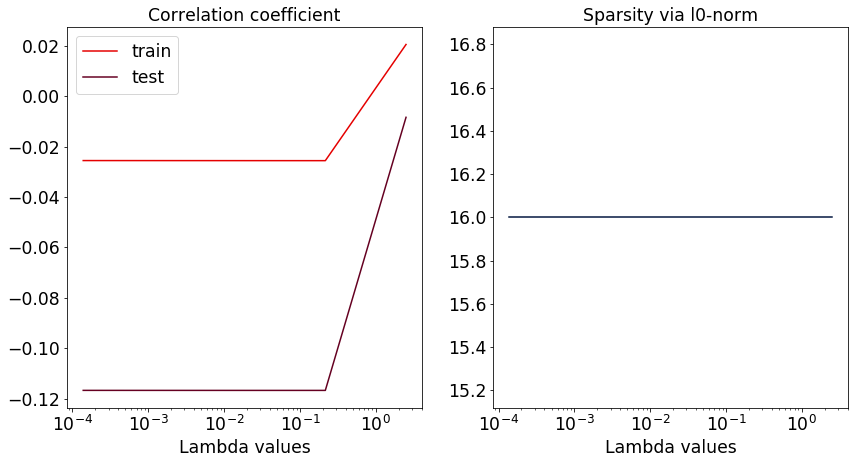

In [5]:
print("Results: subject", _id, ", voxel id", _v)

myfig = plt.figure(figsize=(14,7))
ax_corr = myfig.add_subplot(1, 2, 1)
plt.title("Correlation coefficient", size=_fontsize)
plt.xlabel("Lambda values", size=_fontsize)
ax_corr.set_xscale('log')
ax_corr.plot(todo_lambda, dict_corr_tr[_v], label="train", color="xkcd:red")
ax_corr.plot(todo_lambda, dict_corr_te[_v], label="test", color="xkcd:maroon")
ax_corr.legend(loc="best",ncol=1, fontsize=_fontsize)
ax_corr.tick_params(labelsize=_fontsize)

ax_spar = myfig.add_subplot(1, 2, 2)
plt.title("Sparsity via l0-norm", size=_fontsize)
plt.xlabel("Lambda values", size=_fontsize)
ax_spar.set_xscale('log')
ax_spar.plot(todo_lambda, dict_l0norm[_v], color="xkcd:navy")
ax_spar.tick_params(labelsize=_fontsize)

plt.show()

続いて、全ボクセルまで対象範囲を拡げ、ROIごとの平均的な成績を見ていく。まずは、$\lambda$の候補として多数の値を試しているので、代表的な成績を選ぶ必要がある。訓練、検証、それぞれにおいて相関係数の絶対値がもっとも高かったものを選出する。

In [6]:
num_voxels = len(dict_corr_tr)

best_corr_tr = np.zeros(num_voxels, dtype=np.float32)
best_corr_te = np.zeros(num_voxels, dtype=np.float32)

for v in range(num_voxels):
    
    # Best absolute correlation value.
    best_corr_tr[v] = np.max(np.abs(dict_corr_tr[v]))
    best_corr_te[v] = np.max(np.abs(dict_corr_te[v]))

次はROIの上でのループである。あらかじめ用意した階層型データはここで役に立つ。

In [7]:
dict_roi_corr_tr = {}
dict_roi_corr_te = {}

In [8]:
for roi in idx_clean_ref.keys():
    dict_roi_corr_tr[roi] = np.mean(best_corr_tr[idx_clean_ref[roi]])
    dict_roi_corr_te[roi] = np.mean(best_corr_te[idx_clean_ref[roi]])

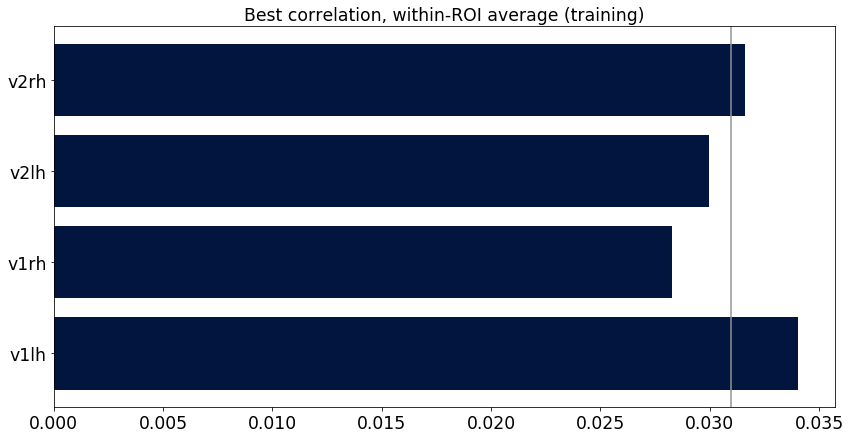

In [16]:
# Training
xvals = list(dict_roi_corr_tr.keys())
yvals = list(dict_roi_corr_tr.values())
myfig = plt.figure(figsize=(14,7))
plt.barh(range(len(dict_roi_corr_tr)), yvals, color="xkcd:navy")
plt.yticks(range(len(dict_roi_corr_tr)), xvals)
plt.title("Best correlation, within-ROI average (training)", size=_fontsize)
plt.axvline(x=np.mean(np.array(yvals)), color="xkcd:gray")
plt.tick_params(labelsize=_fontsize)

plt.show()

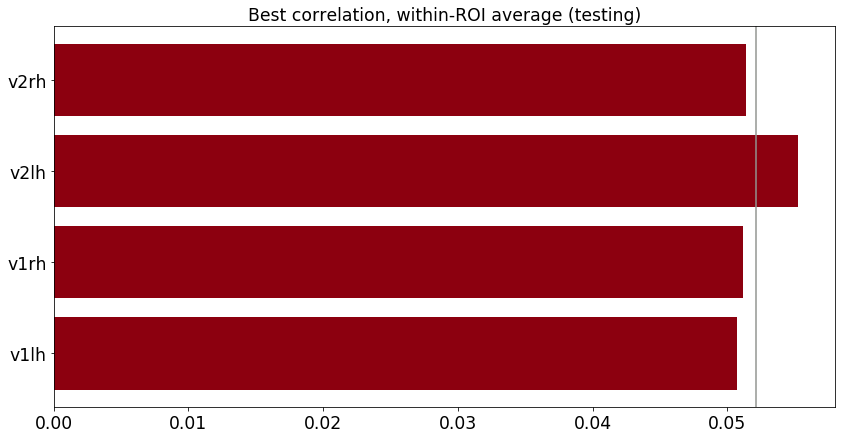

In [17]:
# Testing
xvals = list(dict_roi_corr_te.keys())
yvals = list(dict_roi_corr_te.values())
myfig = plt.figure(figsize=(14,7))
plt.barh(range(len(dict_roi_corr_te)), yvals, color="xkcd:crimson")
plt.yticks(range(len(dict_roi_corr_te)), xvals)
plt.title("Best correlation, within-ROI average (testing)", size=_fontsize)
plt.axvline(x=np.mean(np.array(yvals)), color="xkcd:gray")
plt.tick_params(labelsize=_fontsize)

plt.show()

上記で作ったエンコーダは、ほぼ「無能レベル」である。その理由はアルゴリズム側にもモデル側にも起因するところがある。このノートブックで例示した実装を見て、大幅な性能の改善を図るのが主たる演習課題である。詳細は`vim-2_encoder_practice.pdf`を参照すること。

___